### Fill out:
Name & Surname: Zhen Xue, Gue

Student ID: 33521352

## W5&W6 post studio exercises (time series, imputation)

Enter your solution in the cell(s) below each exercise. Add couple of inline comments explaining your code. Don't forget to add comments in markdown cell after each exercise. Missing comments (in markdown cells and/or inline) and late submissions will incur penalties.

Once done, drag&drop your python file to your ADS1002-name github account.

Copy url of this file on github to appropriate folder on Moodle by 09.30am prior your next studio. 

Solutions will be released later in the semester.

Max 10 marks - 2.5 marks per each exercise.

Required files (download these from the Gitlab site into the same directory as the notebook on your computer):

* [traffic-data.csv](https://gitlab.erc.monash.edu.au/bads/data-challenges-resources/-/tree/main/Pandas-DataFrames/Time-Series/traffic-data.csv)

* [abalone.csv](https://gitlab.erc.monash.edu.au/bads/data-challenges-resources/-/blob/main/Machine-Learning/Imputation/abalone.csv) 

Once downloaded, run the following cells and use these dataframes in the exercises.

In [44]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [45]:
import pandas as pd
# traffic data -Q1, Q2, Q5, Q6
raw_traffic_data = pd.read_csv("traffic-data.csv")

# Create a new index from the timestamp column, with the proper type.
traffic_data = raw_traffic_data.set_index(pd.to_datetime(raw_traffic_data["Timestamp"]))

# Delete the column with our old string representation of times.
traffic_data = traffic_data.drop(columns=["Timestamp"])

traffic_data = traffic_data.assign(
    Date=lambda df: df.index.floor("D"),
    TimeOfDay=lambda df: df.index - df.Date,
    DayOfWeek=lambda df: df.index.day_name().astype("category"),
)

Abalone dataset - This consists of physical measurements of abalones from the Tasmanian coast in the 1990s, in an effort to determine their age. Previously the age would need to be determined in the laboratory by counting the number of rings in the shell. Relationship used to determine age is: 
*Age* = *# of rings + 1.5*. 

This is a complete dataset, however we will randomly remove entries in two columns to perform imputation.

First we load the dataset.

In [46]:
abalone = pd.read_csv("abalone.csv")
abalone.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


The Sex field has three categorical entries: Male (M), Female (F) and Infant (I). Se we need to **one-hot encode** these fields to create three binary columns (encode categorical features to equivalent numerical information).

In [47]:
dummy = pd.get_dummies(abalone['Sex'])
abalone = pd.concat([abalone, dummy], axis=1)
abalone.drop(columns=['Sex'], inplace=True)
abalone.head()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,F,I,M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,False,False,True
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,False,False,True
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,True,False,False
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,False,False,True
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,False,True,False


Lastly we create a features array (X_full) and a target array (Y), the target being Rings. Then we randomly remove 33% of the Height samples and 25% of the Shell weight samples from the features array to get X_rm.

In [48]:
X_full = abalone.drop(columns=['Rings'])
Y = abalone[['Rings']]

X_rm = X_full.copy()
X_rm['Height'] = X_rm['Height'].sample(frac=0.67, random_state = 42)
X_rm['Shell weight'] = X_rm['Shell weight'].sample(frac=0.75, random_state = 64)

#X_rm.describe()

### Exercise 1 (Filtering - traffic_data)

Plot only the data (from the full day) for 18th January 2021 for Site 107 as a line plot. What is the busiest period of the day? Are there any issues with this data? Show data between 1pm and 3p and comment on the values.

### Solution:

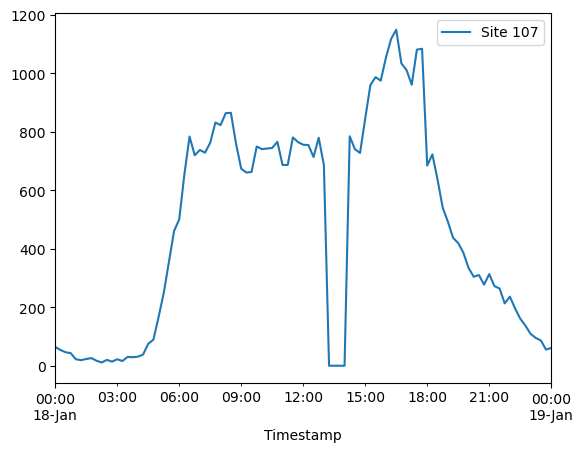

In [49]:
# Filter data for Site 107 and the date 18th January 2021
start = pd.Timestamp("2021-01-18 00:00:00")
end = start + pd.Timedelta(hours=24)
site_107_data = traffic_data.loc[start:end, ["Site 107"]]

# Plot the entire day's traffic data
site_107_data.plot.line();

In [50]:
# Show data between 1pm and 3pm
afternoon_data = site_107_data.between_time("13:00", "15:00")
print(afternoon_data)

                     Site 107
Timestamp                    
2021-01-18 13:00:00     685.0
2021-01-18 13:15:00       0.0
2021-01-18 13:30:00       0.0
2021-01-18 13:45:00       0.0
2021-01-18 14:00:00       0.0
2021-01-18 14:15:00     784.0
2021-01-18 14:30:00     740.0
2021-01-18 14:45:00     727.0
2021-01-18 15:00:00     845.0


Observations:

1. The busiest period occurrs between **15:00 and 17:00** with > 1000 units
2. We see a sudden drop to **0 traffic** between 12:30 and 13:00, which may due to missing data.
3. By looking at the data between 13:00 and 15:00, we see that there is a missing of data that is inconsistent with the data within the period (from 2021-01-18 13:15:00 to 2021-01-18 14:00:00)

### Exercise 2 (Resampling - traffic_data)
Calculate and plot the number of cars seen in the busiest 15 minute period each day for Site 103 (i.e. the maximum of all 15 minute periods across each day). What do you observe?

### Solution:

In [51]:
site_103 = traffic_data[["Site 103"]]

# Compute the sum of all 15 minute counts over each day.
# 1D = group by one day periods
daily = site_103.resample("1D").max()
daily.head() 

,Site 103
Timestamp,
2021-01-01,264.0
2021-01-02,307.0
2021-01-03,303.0
2021-01-04,300.0
2021-01-05,332.0


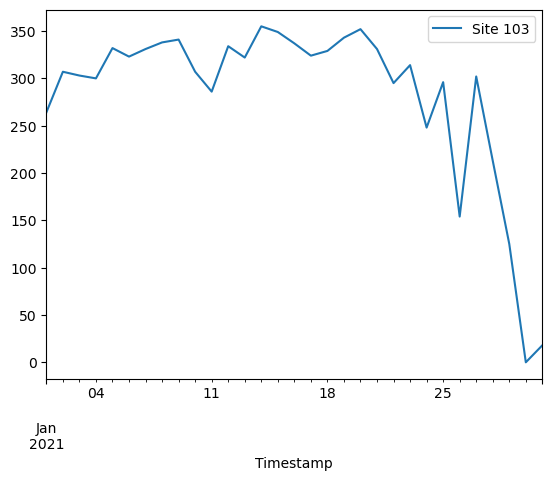

In [52]:
daily.plot.line();

Obv:
1. Max num of cars tends to fluctuate, that, around middle of the month that seems a peak in traffic followed by a decline at the end of the period.

### Exercise 3 (Imputing with mean or median - using X_rm based on abalone)
Consider the dataframe X_simple_imputer below.

For this dataframe:

- Show counts of missing data for all columns. 
- Impute the missing values in the Height column with its mean.
- Impute the missing values in the Shell weight column with its median.
- Show first 10 rows after imputation.
- Show counts of missing data after imputation.

In [53]:
X_simple_imputer = X_rm.copy()

# You may use pandas fill.na() method or SciKit-Learn's simple imputer.

### Solution:

In [54]:
# 3.1: Show counts of missing data for all columns.
missing_counts = X_simple_imputer.isna().sum()
print("Missing Data Counts Before Imputation:")
print(missing_counts)

Missing Data Counts Before Imputation:
Length               0
Diameter             0
Height            1378
Whole weight         0
Shucked weight       0
Viscera weight       0
Shell weight      1044
F                    0
I                    0
M                    0
dtype: int64


In [55]:
# 3.2: Impute the missing values in the Height column with its mean.
from sklearn.impute import SimpleImputer
height_imputer = SimpleImputer(strategy='mean')
X_simple_imputer['Height'] = height_imputer.fit_transform(X_simple_imputer[['Height']])

In [56]:
# 3.3: Impute the missing values in the Shell weight column with its median.
shell_weight_imputer = SimpleImputer(strategy='median')
X_simple_imputer['Shell weight'] = shell_weight_imputer.fit_transform(X_simple_imputer[['Shell weight']])

In [57]:
# 3.4: Show first 10 rows after imputation
X_simple_imputer.head(10)

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,F,I,M
0,0.455,0.365,0.095000,0.5140,0.2245,0.1010,0.150,False,False,True
1,0.350,0.265,0.139176,0.2255,0.0995,0.0485,0.070,False,False,True
2,0.530,0.420,0.135000,0.6770,0.2565,0.1415,0.210,True,False,False
3,0.440,0.365,0.139176,0.5160,0.2155,0.1140,0.155,False,False,True
4,0.330,0.255,0.139176,0.2050,0.0895,0.0395,0.055,False,True,False
5,0.425,0.300,0.139176,0.3515,0.1410,0.0775,0.235,False,True,False
6,0.530,0.415,0.150000,0.7775,0.2370,0.1415,0.235,True,False,False
7,0.545,0.425,0.125000,0.7680,0.2940,0.1495,0.260,True,False,False
8,0.475,0.370,0.125000,0.5095,0.2165,0.1125,0.235,False,False,True
9,0.550,0.440,0.139176,0.8945,0.3145,0.1510,0.320,True,False,False


In [58]:
missing_counts_after = X_simple_imputer.isna().sum()
missing_counts_after

Length            0
Diameter          0
Height            0
Whole weight      0
Shucked weight    0
Viscera weight    0
Shell weight      0
F                 0
I                 0
M                 0
dtype: int64

### Exercise 4 (kNN imputer - X_rm dataframe based on abalone)
Consider the dataframe X_kNN_imputer below. Utilise the kNN imputer with n_neighbors = 5 in order to fill in the missing values of X_kNN_imputer. As we have one hot encoded our data, we will use the MinMaxScaler from SciKit-Learn to normalise our data. After you have done your kNN imputation, please unnormalise your data afterwards!

Also show first 10 entries of the final dataframe.

In [59]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

X_kNN_imputer = X_rm.copy()
Y_kNN_imputer = Y.copy()

# Instantiate the MinMaxScaler
scaler = MinMaxScaler()

# Keep track of the columns
X_columns = X_kNN_imputer.columns 

# Now we normalise the data using the MinMaxScaler. The method used is fit_transform
X_kNN_imputer = pd.DataFrame(scaler.fit_transform(X_kNN_imputer), columns = X_columns)

# X_kNN_imputer has now been normalised. Please do your kNN imputation on this normalised dataframe, and
# then unnormalise your data afterwards using the inverse_transform method of the MinMaxScaler

### Solution:

In [60]:
knn_imputer = KNNImputer(n_neighbors=5)
X_kNN_imputer_imputed = pd.DataFrame(knn_imputer.fit_transform(X_kNN_imputer), columns = X_columns)

# Unnormalise the data
X_kNN_imputer_final = pd.DataFrame(scaler.inverse_transform(X_kNN_imputer_imputed), columns = X_columns)

# Show the first 10 entries of the final dataframe
X_kNN_imputer_final.head(10)

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,F,I,M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,0.0,0.0,1.0
1,0.350,0.265,0.094,0.2255,0.0995,0.0485,0.0700,0.0,0.0,1.0
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,1.0,0.0,0.0
3,0.440,0.365,0.118,0.5160,0.2155,0.1140,0.1550,0.0,0.0,1.0
4,0.330,0.255,0.085,0.2050,0.0895,0.0395,0.0550,0.0,1.0,0.0
5,0.425,0.300,0.107,0.3515,0.1410,0.0775,0.0929,0.0,1.0,0.0
6,0.530,0.415,0.150,0.7775,0.2370,0.1415,0.2503,1.0,0.0,0.0
7,0.545,0.425,0.125,0.7680,0.2940,0.1495,0.2600,1.0,0.0,0.0
8,0.475,0.370,0.125,0.5095,0.2165,0.1125,0.1583,0.0,0.0,1.0
9,0.550,0.440,0.145,0.8945,0.3145,0.1510,0.3200,1.0,0.0,0.0
